# Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Define keypoints using `mediapipe holistic`

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                             ) 

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=4, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=4, circle_radius=2)
                             ) 

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0, 153, 0), thickness=4, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=4, circle_radius=2)
                             ) 

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255, 100, 100), thickness=4, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=4, circle_radius=2)
                             )

In [6]:
cap = cv2.VideoCapture(1)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_styled_landmarks(image, results)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

2024-03-07 15:28:33.724 python[12107:1047188] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1709805514.879815       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# Extracting keypoints values

In [7]:
draw_landmarks(frame, results)

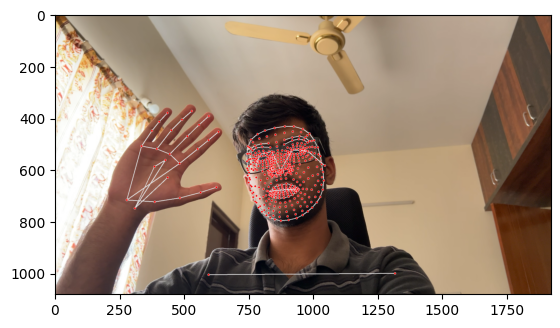

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [9]:
len(results.pose_landmarks.landmark)

33

In [33]:
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) 
    left_hand  = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, face, left_hand, right_hand])

In [37]:
extract_keypoints(results).shape

(1662,)

# Folders for collected data

Each action to be detetcted by the model will have *30* videos. Every video will be *30* frames in length.

In [46]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'thanks', 'iloveyou'])

num_sequences = 30
sequence_length = 30

Creating folders for each action

In [47]:
for action in actions:
    for sequence in range(num_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

Collecting *30* videos per action, i.e. `hello`, `thanks`, and `iloveyou`

Each of the video sequences are going to contain *30* frames of data. Each frame will contain *1662* landmark values.

# Collecting keypoint values for Training and Testing

In [50]:
cap = cv2.VideoCapture(1)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Looping through each action
    for action in actions:

        # Looping through each video
        for sequence in range(num_sequences):

            # Looping through the entire sequence length
            for frame_num in range(sequence_length):

                ret, frame = cap.read()

                # Performing detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)
                
                # Drawing landmarks
                draw_styled_landmarks(image, results)

                # Collecting frames by having delay between each sequence
                if frame_num == 0:
                    cv2.putText(image, 'Staring collection...', (120, 120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {}. Video number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {}. Video number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                
                # Exporting keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1709810880.937255       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# Preprocessing data and creating labels

In [52]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [53]:
label_map = {label: num for num, label in enumerate(actions)}

In [54]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}